In [1]:
import numpy as np
import csv
import ast
import random
import matplotlib.pyplot as plt
#https://prod.liveshare.vsengsaas.visualstudio.com/join?5A63C056021DBD2CBDE16D03FA0977F5C11D

In [2]:
def generate_error():

    error_list = []
    with open('dataset/legitimate_channel_error.csv', newline='') as csvfile:
        
        for line in csvfile:
            error_list.append(ast.literal_eval(line.strip()))

    error_list_clean = [elem[0] if isinstance(elem, tuple) else elem for elem in error_list]

    return error_list_clean

In [3]:
def random_gen(n):
    if n <= 0:
        raise ValueError("n needs to be > 0")
    return random.randint(0, n - 1)

In [4]:
def binary_sum(x,y):

    result = []
    reminder = 0

    for i in reversed(range(len(x))):
        sum = x[i]+y[i]+reminder
        bit = sum%2
        reminder = sum // 2
        result.insert(0,bit)
    
    if reminder:
        result.insert(0,reminder)
    
    return result

In [5]:
def xor(x,y): #probabilmente si potrebbe usare numpy
    result = []
    for i in range(len(x)):
        result.append(x[i] ^ y[i])
    return result

In [6]:
def uniform_wiretap_channel(input, legit_error = generate_error, eve_error = generate_error):

    legitimate_error_list = legit_error()
    eavesdropper_error_list = eve_error()
    legitimate_error = legitimate_error_list[random_gen(8)]
    eavesdropper_error = eavesdropper_error_list[random_gen(8)]

    return (xor(input,legitimate_error),xor(input,eavesdropper_error))




In [7]:
def run_wiretap_simulation(input, num_runs=10**4):
    results = {}

    for _ in range(num_runs):
        y, z = uniform_wiretap_channel(input)

        # Convertiamo le liste x e y in tuple per una gestione più facile nel dizionario
        y_tuple = tuple(y)
        z_tuple = tuple(z)

        if (y_tuple, z_tuple) not in results:
            results[(y_tuple, z_tuple)] = 0
        results[(y_tuple, z_tuple)] += 1

    # Calcoliamo le probabilità
    probabilities = {key: count / num_runs for key, count in results.items()}
    
    return probabilities

# Funzione per dividere le probabilità per x e y
def divide_probabilities(probabilities):
    y_probabilities = {}
    z_probabilities = {}

    # Dividiamo le probabilità
    for (y, z), prob in probabilities.items():
        if y not in y_probabilities:
            y_probabilities[y] = 0
        if z not in z_probabilities:
            z_probabilities[z] = 0
        
        y_probabilities[y] += prob
        z_probabilities[z] += prob

    # Ordinamento delle probabilità
    y_probabilities = dict(sorted(y_probabilities.items()))
    z_probabilities = dict(sorted(z_probabilities.items()))

    return y_probabilities, z_probabilities

In [8]:
probabilities = run_wiretap_simulation([1,0,0,1,0,0,0],num_runs=10**4)
y_probabilities, z_probabilities = divide_probabilities(probabilities)

In [9]:
def plot_pmd_given_symbol_bits(z_probabilities, x=[1, 0, 0, 1, 0, 0, 0]):
    #print("Tipo di z_probabilities:", type(z_probabilities))
    #print("Esempio contenuto:", list(z_probabilities.items())[:5])

    z_values = []
    probabilities = []

    for z_tuple, prob in z_probabilities.items():
        if isinstance(z_tuple, tuple) and isinstance(prob, (int, float)):
            # Converti la tupla binaria in intero
            z_int = int(''.join(map(str, z_tuple)), 2)
            z_values.append(z_int)
            probabilities.append(prob)
        else:
            print("⚠️ Salto coppia non valida:", z_tuple, prob)

    z_values = np.array(z_values)
    probabilities = np.array(probabilities)

    # Ordina i dati per z intero
    sorted_indices = np.argsort(z_values)
    z_values = z_values[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(z_values, probabilities, color='skyblue')
    plt.xlabel("z (valore intero della sequenza binaria)")
    plt.ylabel("PMD")
    plt.title(f'PMD di $Z$ dato {x}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Somma delle probabilità in alto a sinistra
    plt.text(0.01, max(probabilities), f"Somma P = {np.sum(probabilities):.4f}", 
             fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

x = [1, 0, 0, 1, 0, 0, 0]

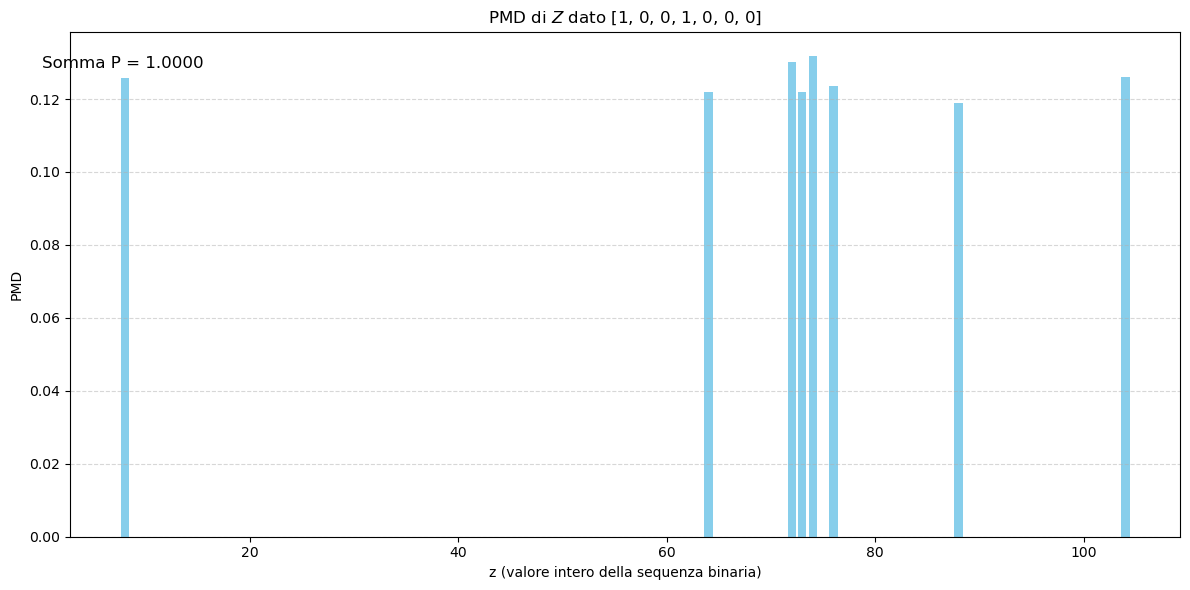

In [10]:
plot_pmd_given_symbol_bits(z_probabilities)

In [11]:
def analyze_error_distribution():
    error_list = generate_error()
    weights = [sum(e) for e in error_list]
    
    from collections import Counter
    distribution = Counter(weights)
    
    print("Distribuzione del peso (numero di bit a 1) nei vettori di errore:")
    for weight, count in sorted(distribution.items()):
        print(f"{weight} bit a 1: {count} occorrenze")

In [12]:
analyze_error_distribution()


Distribuzione del peso (numero di bit a 1) nei vettori di errore:
0 bit a 1: 1 occorrenze
1 bit a 1: 7 occorrenze


## Task 2

In [13]:
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])
#print(f"x = {x}")
#print(y)
#print(z)

def error_correction(y,s):
    H = np.array([
        [1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 0, 1]
    ])

    e_hat = np.zeros_like(y)
    for i in range(7):
        e_i = H[:, i] % 2
        if np.array_equal(s, e_i):
            e_hat[i] = 1
    return xor(y, e_hat)

    

def forward_reconciliation(y, s_A):
    y = np.array(y)
    
    s_B = np.dot(H, y) % 2
    s = xor(s_A, s_B)

    x_hat = error_correction(y, s)

    return x_hat


def simulate_forward_information_reconciliation(channel, legit_error, eve_error, n_runtimes=10**2):

    success_Bob = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = channel(x, legit_error, eve_error)

        s_A = np.dot(H, x) % 2

        x_hat_Bob = forward_reconciliation(y, s_A)
        x_hat_Eve = forward_reconciliation(z, s_A)

        y = np.array(y)
        z = np.array(z)
        #print(y)
        #print(x,"\n")

        if np.array_equal(x, x_hat_Bob):

            success_Bob += 1
        if np.array_equal(x, x_hat_Eve):
            success_Eve += 1  


    return success_Bob/n_runtimes, success_Eve/n_runtimes  



In [14]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=uniform_wiretap_channel,
                                                                    legit_error=generate_error,
                                                                    eve_error=generate_error)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 1.0


## Task 3

In [19]:
#A --> B

def reverse_reconciliation(x, s_B):
    x = np.array(x)
    
    s_A = np.dot(H, x) % 2
    s = xor(s_A, s_B)

    y_hat = error_correction(x, s)
    
    return y_hat


def simulate_reverse_information_reconciliation(n_runtimes=10**2):

    success_Alice = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = uniform_wiretap_channel(x)

        s_B = np.dot(H, y) % 2 

        y_hat_Alice = reverse_reconciliation(x, s_B)
        y_hat_Eve = reverse_reconciliation(z, s_B)
        

        if np.array_equal(y, y_hat_Alice):
            success_Alice += 1
        if np.array_equal(y, y_hat_Eve):
            success_Eve += 1   
    return success_Alice/n_runtimes, success_Eve/n_runtimes  


In [20]:
success_Alice, success_Eve = simulate_reverse_information_reconciliation()

print(f"Success probability of information reconciliation for Bob: {success_Alice}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 0.34


## Task 4

In [ ]:
def det_privacy_amplification(x, A):
    return np.dot(A, x) % 2


def prob_privacy_amplification(x, l):
    assert len(x) == 4
    M = np.random.randint(0, 2, size=(l, 4))
    result = np.dot(M,x) % 2
    return result


def privacy_amplification(x, A, l):
    x_prime = det_privacy_amplification(x, A)
    k = prob_privacy_amplification(x_prime, l)
    return k

## Task 6

In [36]:
def binary_symmetric_channel(input,error):
    output=[]
    for bit in input:
        if random.random() <= error:
                output.append(bit ^ 1)
        else:
                output.append(bit)

    return output


def wiretap_bsc(x, legit_error = 0.1, eaves_error = 0.3):
    y = binary_symmetric_channel(x, legit_error)
    z = binary_symmetric_channel(x, eaves_error)
    return y, z

In [43]:
def evaluate_BSC(error=0.1,iterations=10**5):
    x = [0,0,0,0,0,0,0]
    #error = 0.1
    n_bit_error = 0

    for i in range(iterations):
        x_bsc = binary_symmetric_channel(x,error)
        for i in range(7):
            if x_bsc[i]==1:
                n_bit_error+=1

    return n_bit_error, n_bit_error/(iterations*len(x))

In [44]:
errors = [0.1, 0.3, 0.5, 0.7]
for error in errors:
    iterations = 10**5
    n_bit_error, error_rate = evaluate_BSC(error, iterations)
    print(f"Average number of errors in BSC with error rate {error}: {error_rate:.4f} ({n_bit_error} errors in {iterations} iterations)")

Average number of errors in BSC with error rate 0.1: 0.1002 (70115 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.3: 0.2995 (209629 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.5: 0.5003 (350212 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.7: 0.6995 (489634 errors in 100000 iterations)


In [37]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=wiretap_bsc,
                                            legit_error=0.1,
                                            eve_error=0.3)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


[1 1 1]
x =  [0 1 1 0 1 0 0]
y =  [0 1 1 0 1 0 1]
x_hat =  [0 1 1 0 1 0 0]
[0 0 1]
x =  [0 1 1 0 1 0 0]
y =  [0 0 1 0 0 1 0]
x_hat =  [0 0 0 0 0 1 0]
[1 1 0]
x =  [0 0 0 1 0 0 1]
y =  [0 0 0 1 0 1 1]
x_hat =  [0 0 0 1 0 0 1]
[0 1 0]
x =  [0 0 0 1 0 0 1]
y =  [0 0 1 0 0 0 1]
x_hat =  [0 1 1 0 0 0 1]
[1 1 1]
x =  [0 0 1 1 0 1 1]
y =  [0 0 1 1 0 1 0]
x_hat =  [0 0 1 1 0 1 1]
[1 0 0]
x =  [0 0 1 1 0 1 1]
y =  [1 0 1 1 0 1 1]
x_hat =  [0 0 1 1 0 1 1]
[1 0 1]
x =  [0 1 1 0 1 1 0]
y =  [0 1 1 0 0 1 0]
x_hat =  [0 1 1 0 1 1 0]
[0 0 0]
x =  [0 1 1 0 1 1 0]
y =  [0 1 1 0 1 1 0]
x_hat =  [0 1 1 0 1 1 0]
[0 0 0]
x =  [0 0 1 0 0 0 0]
y =  [0 0 1 0 0 0 0]
x_hat =  [0 0 1 0 0 0 0]
[0 1 0]
x =  [0 0 1 0 0 0 0]
y =  [0 0 1 1 0 1 1]
x_hat =  [0 1 1 1 0 1 1]
[0 1 1]
x =  [1 0 1 0 1 0 0]
y =  [1 0 1 1 1 0 0]
x_hat =  [1 0 1 0 1 0 0]
[1 0 1]
x =  [1 0 1 0 1 0 0]
y =  [1 0 1 0 0 0 0]
x_hat =  [1 0 1 0 1 0 0]
[0 1 1]
x =  [0 1 1 0 1 1 1]
y =  [0 1 1 1 1 1 1]
x_hat =  [0 1 1 0 1 1 1]
[1 0 0]
x =  [0 1 1 0 1 1